## Used packages

In [162]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from SALib.analyze import sobol
from ema_workbench.analysis import feature_scoring

import warnings
warnings.filterwarnings("ignore")

In [163]:
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,

)
from dike_model_function import DikeNetwork  # @UnresolvedImport
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

from ema_workbench import perform_experiments
from ema_workbench import Samplers
from ema_workbench import SequentialEvaluator
from ema_workbench.em_framework.parameters import Constant

## Creating samples LHC 

In [164]:
# Create an instance of the model which is usable with the EMA workbench
dike_model, planning_steps = get_model_for_problem_formulation(3)

to only focus on the scenarios no policies should be taken into account. Code below set all the 

In [165]:
zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)

In [166]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=2000,policies=policy0,uncertainty_sampling=Samplers.LHS)

experiments, outcomes = results

100%|██████████████████████████████████████| 2000/2000 [03:23<00:00,  9.85it/s]


## Preprocess data samples LHC 

In [167]:
experiments_unc =experiments.iloc[:,0:19]

In [168]:
outcomes.keys()

dict_keys(['A.1 Total Costs', 'A.1_Expected Number of Deaths', 'A.2 Total Costs', 'A.2_Expected Number of Deaths', 'A.3 Total Costs', 'A.3_Expected Number of Deaths', 'A.4 Total Costs', 'A.4_Expected Number of Deaths', 'A.5 Total Costs', 'A.5_Expected Number of Deaths', 'RfR Total Costs', 'Expected Evacuation Costs'])

In [169]:
df = pd.DataFrame(outcomes) 
df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df["A.5 Total Costs"]

In [170]:
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df["A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]

In [171]:
outcomes_feaimp = outcomes

In [172]:
df_feature_importance_out = df[["Total Costs", "Expected Number of Deaths","A.5_Expected Number of Deaths", "A.5 Total Costs"]]

## Feature importance

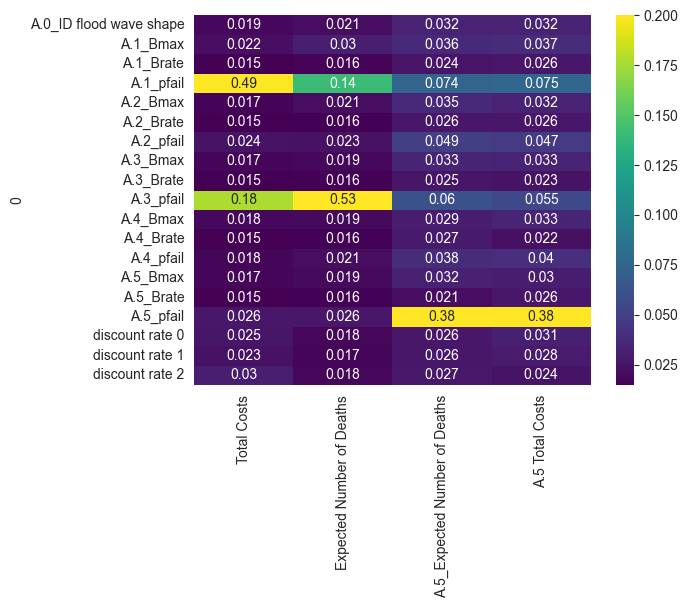

In [173]:
x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True,vmax=0.2)
plt.show()

## Filter important uncertainties and create samples SOBOL 

In [174]:
dike_model_1, planning_steps = get_model_for_problem_formulation(3)

zero_policy = {"DaysToThreat": 0}
zero_policy.update({f"DikeIncrease {n}": 0 for n in planning_steps})
zero_policy.update({f"RfR {n}": 0 for n in planning_steps})

pol0 = {}

for key in dike_model_1.levers:
    s1, s2 = key.name.split("_")
    pol0.update({key.name: zero_policy[s2]})

policy0 = Policy("Policy 0", **pol0)
print()

In [175]:
dele = []
for x in dike_model_1.uncertainties:
    if x.name not in ["A.1_pfail","A.2_pfail","A.3_pfail","A.4_pfail","A.5_pfail"]:
        dele.append(x.name)
for i in dele:
    dike_model_1.uncertainties.__delitem__(i)


dike_model_1.constants.extend(Constant("discount rate 0",1))
dike_model_1.constants.extend(Constant("discount rate 1",1))
dike_model_1.constants.extend(Constant("discount rate 2",1))

dike_model_1.constants.extend(Constant('A.0_ID flood wave shape',1))

dike_model_1.constants.extend(Constant('A.1_Bmax',190))
dike_model_1.constants.extend(Constant('A.1_Brate',1.5))

dike_model_1.constants.extend(Constant('A.2_Bmax',190))
dike_model_1.constants.extend(Constant('A.2_Brate',1.5))

dike_model_1.constants.extend(Constant('A.3_Bmax',190))
dike_model_1.constants.extend(Constant('A.3_Brate',1.5))

dike_model_1.constants.extend(Constant('A.4_Bmax',190))
dike_model_1.constants.extend(Constant('A.4_Brate',1.5))

dike_model_1.constants.extend(Constant('A.5_Bmax',190))
dike_model_1.constants.extend(Constant('A.5_Brate',1.5))


In [176]:
with MultiprocessingEvaluator(dike_model_1) as evaluator:
    results = evaluator.perform_experiments(scenarios=200,policies=policy0,uncertainty_sampling=Samplers.SOBOL)

experiments, outcomes = results

100%|██████████████████████████████████████| 2400/2400 [04:24<00:00,  9.07it/s]


## Preprocess data samples LHC 

In [177]:
experiments_unc =experiments.iloc[:,0:5]

In [178]:
df =pd.DataFrame(outcomes)

In [179]:

df["Total Costs"] = df["A.1 Total Costs"] + df["A.2 Total Costs"] + df["A.3 Total Costs"] + df["A.4 Total Costs"] + df[
    "A.5 Total Costs"]
df["Expected Number of Deaths"] = df["A.1_Expected Number of Deaths"] + df["A.2_Expected Number of Deaths"] + df[
    "A.3_Expected Number of Deaths"] + df["A.4_Expected Number of Deaths"] + df["A.5_Expected Number of Deaths"]


In [180]:
outcomes["Total Costs"] = df["Total Costs"]
outcomes["Expected Number of Deaths"] = df["Expected Number of Deaths"]

## Feature importance (not required but nice to know)

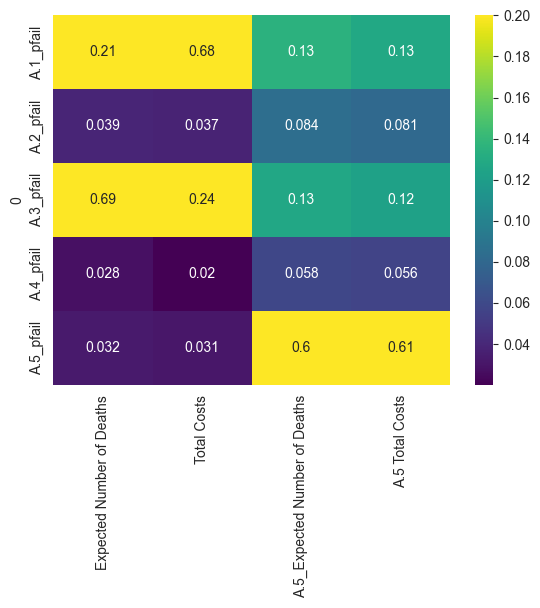

In [181]:
df_feature_importance_out = df[
    ["Expected Number of Deaths","Total Costs","A.5_Expected Number of Deaths", "A.5 Total Costs"]]

x = experiments_unc
y = df_feature_importance_out

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True, vmax=0.2)
plt.show()

## SOBOL analysis 

In [182]:
problem = get_SALib_problem(dike_model_1.uncertainties)


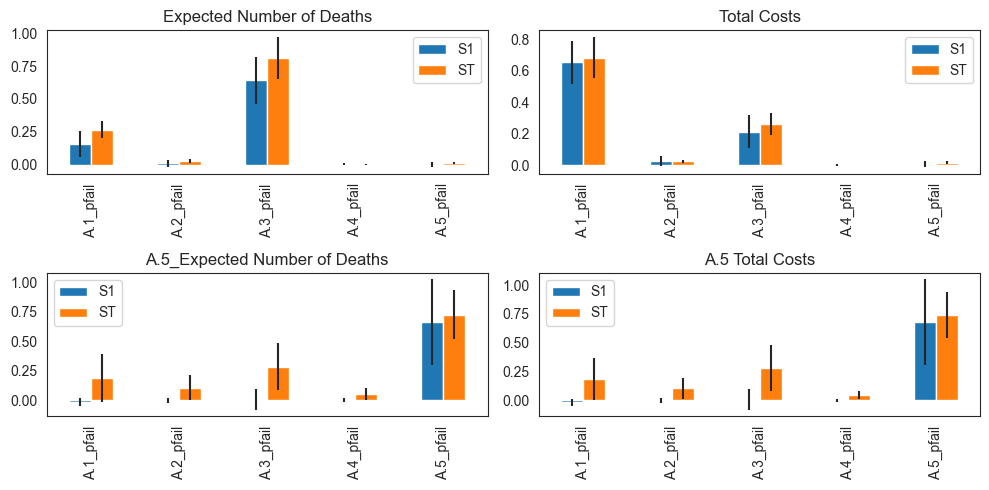

In [183]:
sns.set_style('white')
fig, ax = plt.subplots(2,2,figsize=(10,5))
ax = ax.flatten()

for index,kpi in enumerate(df_feature_importance_out.columns):
    Si = sobol.analyze(problem,np.array(outcomes[kpi]), calc_second_order=True, print_to_console=False)
    Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(Si_filter, index=problem['names'])
    
    
    
    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]
    ax[index].title.set_text(kpi) 
    indices.plot.bar(yerr=err.values.T,ax=ax[index])
    # fig.set_size_inches(8,6)
    # fig.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()